# Laboratory №6

### Task 1

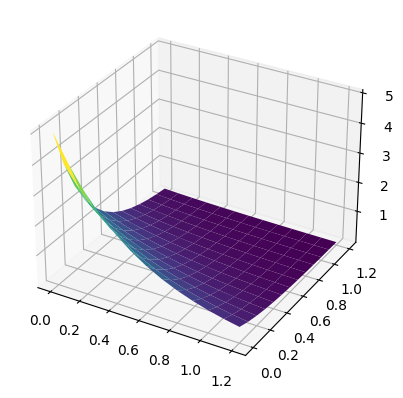

In [123]:
import csv
import numpy as np
import sympy as sym

from matplotlib import pyplot as plt

file = "input.csv"

N = 10

def func(x):
    return x ** 2

def readFromFile(file):
    Table = []

    with open(file) as f:
        reader = csv.DictReader(f)

        for row in reader:
            Table.append(np.array(list(map(float, [*row.values()]))))

    return Table

def quadratureFormula(n: int):
    if n % 2 == 0: return 2 / (n + 1) 
    else: return 0

def getLegendrePoly(num: int):

    x = sym.symbols("x")
    func = f"(x**2-1)**{num} / (2 ** {num})"
    func = sym.sympify(func)
    func = func / sym.factorial(num)

    return sym.Derivative(func, (x, num)).doit()

def solveSystem(polyZeros):

    matrix = np.array([polyZeros ** i for i in range(N)], dtype="float")
    matrix.reshape((N, N))

    BCoefs = np.array([quadratureFormula(i) for i in range(N)], dtype="float")
    BCoefs.reshape((N, 1))

    return np.linalg.solve(matrix, BCoefs)

def solveIntegral(a, b, func, ACoefs, polyZeros):

    xValues = (b + a) / 2 + (b - a) * polyZeros / 2
    funcValues = func(xValues)

    return (b - a) * np.sum(ACoefs * funcValues) / 2

poly = getLegendrePoly(N)
polyZeros = np.array(sym.solve(poly.doit(), sym.Symbol('x')))
polyZeros = np.sort(polyZeros) 

# polyZeros - нули полинома Лежандра
# ACoefs - A коэффициенты

ACoefs = solveSystem(polyZeros)

# ans = solveIntegral(-2, 2, func, ACoefs, polyZeros)
# print(ans)

Table = np.array(readFromFile(file))
x, y = np.meshgrid(Table[:, 0], Table[:, 0])
z = Table[:, 2:]

ax = plt.axes(projection="3d")
ax.plot_surface(x, y, z, cmap = "viridis")
plt.show()


In [153]:
def func1(x):
    return x ** 2

def simpson(a, b, func):
    
    h = (b - a) / N
    edge = int(N / 2)
    xValues = np.linspace(a, b, 2 * N + 1)

    return h * np.sum([func(xValues[2 * i]) + 4 * func(xValues[2 * i + 1]) + func(xValues[2 * i + 2]) for i in range(edge)]) / 3

print(simpson(-2, 2, func1))

5.333333333333333


### Task 2

In [165]:
import numpy as np
import prettytable as pt

N = 6

def formatOut(num):
    return f"{num:.5f}"

def leftDiffDer(yValue, step, index):
    if index > 0:
        return formatOut((yValue[index] - yValue[index - 1]) / step)
    else:
        return '*'

def centerDiffDer(yValue, step, index):
    if index > 0 and index < N - 1:
        return formatOut((yValue[index + 1] - yValue[index - 1]) / (2 * step))
    else:
        return '*'

def secondRunge(yValue, step, index):
    if index < 2:
        return '*'
        
    f1 = (yValue[index] - yValue[index - 1]) / (step)
    f2 = (yValue[index] - yValue[index - 2]) / (2 * step)

    return formatOut(2 * f1 - f2)

def aligVars(yValue, xValue, index):
    if index > N - 2:
        return '*'

    d = (1 / yValue[index + 1] - 1 / yValue[index]) / \
        (1 / xValue[index + 1] - 1 / xValue[index])

    return formatOut(d * yValue[index] ** 2 / xValue[index] ** 2)

def secondDiffDer(yValue, step, index):
    if index > 0 and index < N - 1:
        return formatOut((yValue[index - 1] - 2 * yValue[index] + yValue[index + 1]) / step ** 2)
    else:
        return ' *'

xArr = [1, 2, 3, 4, 5, 6]
yArr = [0.571, 0.889, 1.091, 1.231, 1.333, 1.412]
    
step = (xArr[-1] - xArr[0]) / len(xArr)

methods = [leftDiffDer, centerDiffDer, 
           secondRunge, aligVars, 
           secondDiffDer]

In [166]:
table = pt.PrettyTable()
filedNames = ["X", "Y", "1", "2", "3", "4", "5"]

table.add_column(filedNames[0], xArr)
table.add_column(filedNames[1], yArr)

for i in range(len(methods)):
    if i == 3:
        table.add_column(filedNames[i + 1], [methods[i](yArr, xArr, j) for j in range(N)])
    else:    
        table.add_column(filedNames[i + 2], [methods[i](yArr, step, j) for j in range(N)])

print(table)

+---+-------+---------+---------+---------+---------+----------+
| X |   Y   |    1    |    2    |    3    |    3    |    5     |
+---+-------+---------+---------+---------+---------+----------+
| 1 | 0.571 |    *    |    *    |    *    | 0.40850 |     *    |
| 2 | 0.889 | 0.38160 | 0.31200 |    *    | 0.24690 | -0.16704 |
| 3 | 1.091 | 0.24240 | 0.20520 | 0.17280 | 0.16544 | -0.08928 |
| 4 | 1.231 | 0.16800 | 0.14520 | 0.13080 | 0.11774 | -0.05472 |
| 5 | 1.333 | 0.12240 | 0.10860 | 0.09960 | 0.08950 | -0.03312 |
| 6 | 1.412 | 0.09480 |    *    | 0.08100 |    *    |     *    |
+---+-------+---------+---------+---------+---------+----------+
